In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import scoring_utils

In [2]:
df = pd.read_csv('../data/data_clean.csv')

for col in df.columns:
    print(col)

City
State
Bank
ApprovalFY
Term
NoEmp
CreateJob
RetainedJob
FranchiseCode
UrbanRural
RevLineCr
LowDoc
GrAppv
SBA_Appv
Default
NAICS_i
isNewBusiness
isFranchise
SBARatio
InterestRate


In [3]:
# one-hot encode UrbanRural and include it
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

UR_encoded = OHE.fit_transform(df[['UrbanRural']])
UR_enc_df = pd.DataFrame(UR_encoded,columns = OHE.get_feature_names_out(['UrbanRural']))
df = pd.concat([df,UR_enc_df], axis=1)
df.drop(columns=['UrbanRural'], inplace=True)


In [4]:
# Look for and remove outliers

def remove_outliers(df:pd.DataFrame, c:str):
    z_scores = np.abs((df[c] - df[c].mean())/df[c].std())
    no_outliers = df[z_scores < 3]
    return no_outliers

#remove outliers from features

have_outliers = ['Term','NoEmp','CreateJob','RetainedJob','GrAppv','SBA_Appv']

for col in have_outliers:
    print(f"\n\nCol: {col}")
    print("\nBefore:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')
    df = remove_outliers(df,col)
    print("\nAfter:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')




Col: Term

Before:
	count    870514.000000
	mean        111.508946
	std          79.177488
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         569.000000

After:
	count    870352.000000
	mean        111.458809
	std          79.097905
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         349.000000


Col: NoEmp

Before:
	count    870352.000000
	mean         11.478524
	std          74.594736
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max        9999.000000

After:
	count    868960.000000
	mean         10.020323
	std          17.337608
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max         235.000000


Col: CreateJob

Before:
	count    868960.000000
	mean          8.526285
	std         239.181681
	min           0.000000
	25%           0.000000
	50%           0.000000
	75

In [5]:
# Select Features (X) and Target (Y)
#X = df[['ApprovalFY','Term','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','RevLineCr','LowDoc','GrAppv','SBA_Appv','NAICS_i','isNewBusiness','isFranchise','SBARatio','InterestRate']]
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
target = 'Default'
features = [f for f in df.columns if f not in experimental_features and f not in target]

X = df[features]
Y = df[target]

In [6]:
# Do a train-test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X,Y,test_size=0.1,random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=.5)



In [7]:
# Scale Features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_cv_scaled = sc.transform(X_cv)
X_test_scaled = sc.transform(X_test)
X_scaled =sc.transform(X)

In [8]:
# initialize the  model
logit = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5, C=0.4, verbose=2, n_jobs=-1, class_weight='balanced')
logit.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.05065040
Epoch 3, change: 0.01388183
Epoch 4, change: 0.00937884
Epoch 5, change: 0.00819281
Epoch 6, change: 0.00392971
Epoch 7, change: 0.00356854
Epoch 8, change: 0.00327213
Epoch 9, change: 0.00281539
Epoch 10, change: 0.00406598
Epoch 11, change: 0.00362525
Epoch 12, change: 0.00230455
Epoch 13, change: 0.00205386
Epoch 14, change: 0.00196042
Epoch 15, change: 0.00178958
Epoch 16, change: 0.00165916
Epoch 17, change: 0.00152212
Epoch 18, change: 0.00141458
Epoch 19, change: 0.00131291
Epoch 20, change: 0.00120005
Epoch 21, change: 0.00110551
Epoch 22, change: 0.00102581
Epoch 23, change: 0.00095048
Epoch 24, change: 0.00086870
Epoch 25, change: 0.00081062
Epoch 26, change: 0.00075237
Epoch 27, change: 0.00068415
Epoch 28, change: 0.00063174
Epoch 29, change: 0.00059033
Epoch 30, change: 0.00054445
Epoch 31, change: 0.00049984
Epoch 32, change: 0.00046278
Epoch 33, change: 0.00042704
Epoch 34, change: 0.00039505
Epoch 35, change: 0.000

LogisticRegression(C=0.4, class_weight='balanced', l1_ratio=0.5, n_jobs=-1,
                   penalty='elasticnet', solver='saga', verbose=2)

In [9]:
coefficients = logit.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print(coef_df)

          Feature  Coefficient
0            Term    -1.938824
1           NoEmp    -0.303952
2       CreateJob    -0.000497
3     RetainedJob     0.012658
4       RevLineCr    -0.083976
5          LowDoc    -0.334888
6          GrAppv     0.045914
7        SBA_Appv     0.265978
8   isNewBusiness    -0.001707
9     isFranchise     0.017329
10       SBARatio     0.290627
11   InterestRate     0.502774
12   UrbanRural_0    -0.473197
13   UrbanRural_1     0.340181
14   UrbanRural_2     0.146258


In [10]:
#make predictions
yhat_train = logit.predict(X_train_scaled)
yhat_cv = logit.predict(X_test_scaled)

score = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train, "Logit Train"),
    scoring_utils.get_metrics(y_test, yhat_cv, "Logit CV")
])

score

,Recall,Precision,ROC,F1
Logit Train,0.824652,0.385974,0.769953,0.525834
Logit CV,0.821595,0.382523,0.768576,0.522007


In [11]:
logit.get_params()

{'C': 0.4,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.5,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 2,
 'warm_start': False}

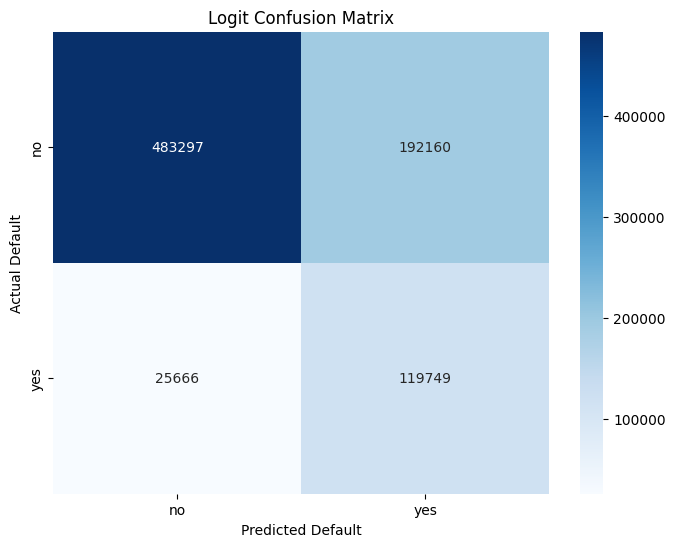

In [12]:
yhat_total = logit.predict(X_scaled)
scoring_utils.get_confusion_matrix(Y, yhat_total, "Logit")

In [13]:
scoring_utils.get_profit(X, Y, yhat_total)

3474640626.7000003

This fucker overfits to the max. You need to regularize it as crazy. You can keep all the columns if you want to but it's not necessary. First, do something similar to the code in importance_analysis (the graphs that draw a line for CV and a line for testing) and iterate over different types of regularization.
If I was you I would pick elasticnet with a saga solver and iterate over different values of l1. The docs explain pretty good. Then change the solver and try with other penalties.